In [70]:
import pandas as pd # type: ignore

data = pd.read_csv("preprocessed_data/model_train.csv")


In [71]:
dataset = data.head(100_000)
dataset.shape

(100000, 10)

In [72]:
dataset

,id.orig_p,id.resp_p,proto,conn_state,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,encoding
0,24104.0,23.0,tcp,S0,1.0,40.0,0.0,0.0,Benign,0.0
1,23390.0,62336.0,tcp,OTH,0.0,0.0,0.0,0.0,Malicious,1.0
2,53994.0,52869.0,tcp,S0,1.0,40.0,0.0,0.0,Malicious,1.0
3,55386.0,22.0,tcp,S0,1.0,40.0,0.0,0.0,Malicious,1.0
4,38114.0,8081.0,tcp,S0,1.0,40.0,0.0,0.0,Malicious,1.0
...,...,...,...,...,...,...,...,...,...,...
99995,17576.0,8081.0,tcp,S0,2.0,80.0,0.0,0.0,Malicious,1.0
99996,63420.0,23.0,tcp,S0,2.0,80.0,0.0,0.0,Malicious,1.0
99997,24159.0,8081.0,tcp,S0,6.0,240.0,0.0,0.0,Malicious,1.0
99998,38370.0,37215.0,tcp,S0,1.0,40.0,0.0,0.0,Malicious,1.0


In [73]:
data.isnull().sum()/data.shape[0]*100

id.orig_p        0.0
id.resp_p        0.0
proto            0.0
conn_state       0.0
orig_pkts        0.0
orig_ip_bytes    0.0
resp_pkts        0.0
resp_ip_bytes    0.0
label            0.0
encoding         0.0
dtype: float64

In [74]:
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # type: ignore
from sklearn.preprocessing import OneHotEncoder # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.pipeline import Pipeline # type: ignore

# Load dataset
data = dataset

# Check for and handle NaN values in the label column
data = data.dropna(subset=['encoding'])

# Prepare features and labels
X = data.drop(['label', 'encoding'], axis=1)
y = data['encoding']


categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

def create_pipeline(steps):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        *steps
    ])
    return pipeline

In [75]:
y_train.value_counts()

encoding
1.0    66420
0.0     8580
Name: count, dtype: int64

In [76]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.preprocessing import StandardScaler

# Create a pipeline with preprocessing and logistic regression
lr = create_pipeline([
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Train the model
lr.fit(X_train, y_train)

/Users/dewelz/Documents/workspace/fyp/env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['proto', 'conn_state'], dtype='object'))])),
                ('scale', StandardScaler()),
                ('classifier', LogisticRegression(max_iter=10000))])

In [77]:
# Predict and evaluate
pred_lr = lr.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, pred_lr) * 100}")
print(f"Precision: {precision_score(y_test, pred_lr) * 100}")
print(f"Recall: {recall_score(y_test, pred_lr) * 100}")
print(f"F1 Score: {f1_score(y_test, pred_lr) * 100}")

Accuracy: 88.972
Precision: 92.5054752518616
Recall: 95.28084818407399
F1 Score: 93.87265251694633


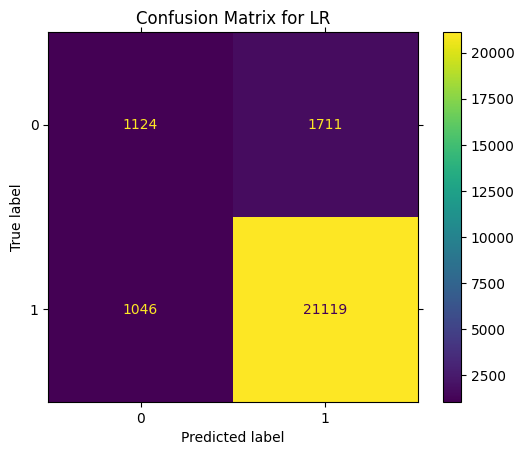

In [78]:
import matplotlib.pyplot as plt # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # type: ignore

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_lr)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for LR")
plt.show()


Random Forest.

In [79]:
from sklearn.ensemble import RandomForestClassifier

rfc = create_pipeline([
    ("random_forest", RandomForestClassifier(n_estimators = 10, min_samples_split = 5, min_samples_leaf = 2))
])
rfc.fit(X_train, y_train)

/Users/dewelz/Documents/workspace/fyp/env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['proto', 'conn_state'], dtype='object'))])),
                ('random_forest',
                 RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=10))])

In [80]:
pred_rfc = rfc.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, pred_rfc) * 100}")
print(f"Precision score: {precision_score(y_test, pred_rfc) * 100}")
print(f"Recall score: {recall_score(y_test, pred_rfc) * 100}")
print(f"F1 score: {f1_score(y_test, pred_rfc) * 100}")


Accuracy score: 99.96000000000001
Precision score: 99.96842437638144
Recall score: 99.98646514775547
F1 score: 99.9774439482113


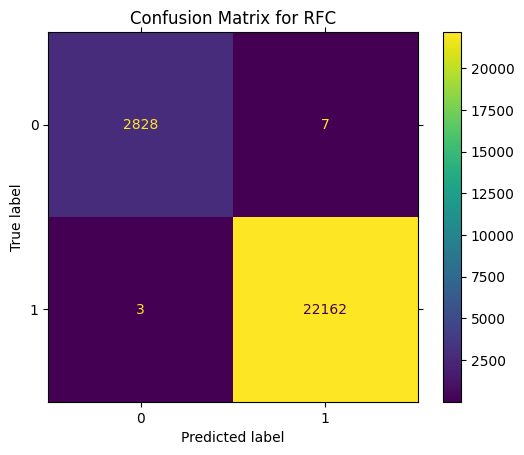

In [81]:
import matplotlib.pyplot as plt # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # type: ignore

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_rfc)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for RFC")
plt.show()

HISTOGRAM BASED GRADIENT BOOSTING CLASSIFIER

In [82]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import FunctionTransformer

hgbc = create_pipeline([
    # ("dense", FunctionTransformer(lambda x: np.asarray(x), accept_sparse=True)),
    ("histogram_gradient_boost", HistGradientBoostingClassifier())
])


hgbc.fit(X_train, y_train)


/Users/dewelz/Documents/workspace/fyp/env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['proto', 'conn_state'], dtype='object'))])),
                ('histogram_gradient_boost', HistGradientBoostingClassifier())])

In [83]:
pred_hgbc = hgbc.predict(X_test)

print(f"Accuracy score: {accuracy_score(y_test, pred_hgbc) * 100}")
print(f"Precision score: {precision_score(y_test, pred_hgbc) * 100}")
print(f"Recall score: {recall_score(y_test, pred_hgbc) * 100}")
print(f"F1 score: {f1_score(y_test, pred_hgbc) * 100}")

Accuracy score: 99.9
Precision score: 99.98193967852627
Recall score: 99.90525603428829
F1 score: 99.94358314715772


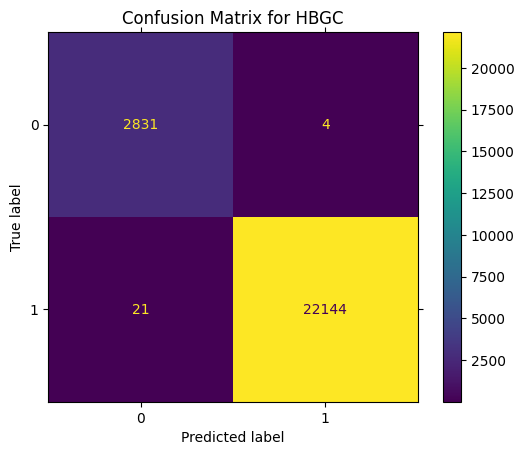

In [84]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_hgbc)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for HBGC")
plt.show()

SUPPORT VECTOR MACHINE.

In [85]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svc = create_pipeline([
    ('scale', StandardScaler(with_mean=False)),
    ('svm', svm.SVC(cache_size=1000, kernel="linear"))
])

XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size=0.75, random_state=15)
svc.fit(XX_train, yy_train)

/Users/dewelz/Documents/workspace/fyp/env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['proto', 'conn_state'], dtype='object'))])),
                ('scale', StandardScaler(with_mean=False)),
                ('svm', SVC(cache_size=1000, kernel='linear'))])

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred_svc = svc.predict(XX_test)
print(f"Accuracy score: {accuracy_score(yy_test, pred_svc) * 100}")
print(f"Precision score: {precision_score(yy_test, pred_svc) * 100}")
print(f"Recall score: {recall_score(yy_test, pred_svc) * 100}")
print(f"F1 score: {f1_score(yy_test, pred_svc) * 100}")

Accuracy score: 92.96
Precision score: 96.84542586750788
Recall score: 95.15512623754928
F1 score: 95.99283567590541


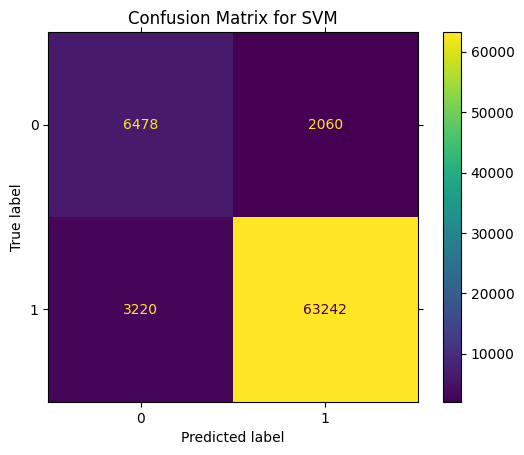

In [87]:
import matplotlib.pyplot as plt # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # type: ignore

# Compute confusion matrix
cm = confusion_matrix(yy_test, pred_svc)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix for SVM")
plt.show()

In [88]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

hgbr = create_pipeline([
    ("grad_boost_regress", HistGradientBoostingRegressor())
])

hgbr.fit(X_train, y_train)

pred_hgbr = hgbr.predict(X_test)



In [89]:
print(f"mean_absolute_error: {mean_absolute_error(y_test,  pred_hgbr)}")
print(f"mean_squared_error: {mean_squared_error(y_test, pred_hgbr)}")
print(f"mean_squared_error: {mean_squared_error(y_test, pred_hgbr, squared=False)}")
print(f"median_absolute_error: {median_absolute_error(y_test, pred_hgbr)}")
print(f"r2_score: {r2_score(y_test, pred_hgbr)}")


mean_absolute_error: 0.0030336544284544427
mean_squared_error: 0.00120043285156468
mean_squared_error: 0.03464726326226474
median_absolute_error: 1.5282257999071902e-05
r2_score: 0.9880601989451739


/Users/dewelz/Documents/workspace/fyp/env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [90]:
#K-Nearest-Neighbor


from sklearn.neighbors import KNeighborsClassifier

knnc = create_pipeline([
    ("k_nearest_neighbors", KNeighborsClassifier(n_neighbors=1000))
])

knnc.fit(X_train, y_train)


/Users/dewelz/Documents/workspace/fyp/env/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['proto', 'conn_state'], dtype='object'))])),
                ('k_nearest_neighbors',
                 KNeighborsClassifier(n_neighbors=1000))])

In [91]:
pred_knn = knnc.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, pred_knn) * 100}")
print(f"Precision score: {precision_score(y_test, pred_knn) * 100}")
print(f"Recall score: {recall_score(y_test, pred_knn) * 100}")
print(f"F1 score: {f1_score(y_test, pred_knn) * 100}")

Accuracy score: 89.092
Precision score: 90.78130245048675
Recall score: 97.6088427701331
F1 score: 94.07135247950953


CLASSIFICATION REPORT

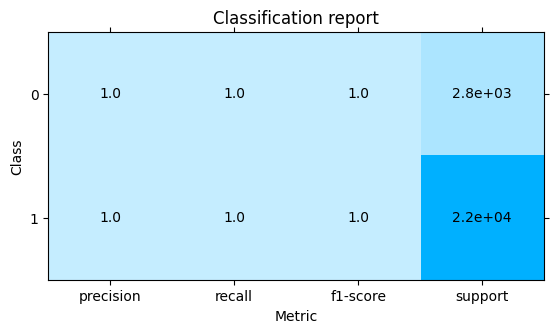

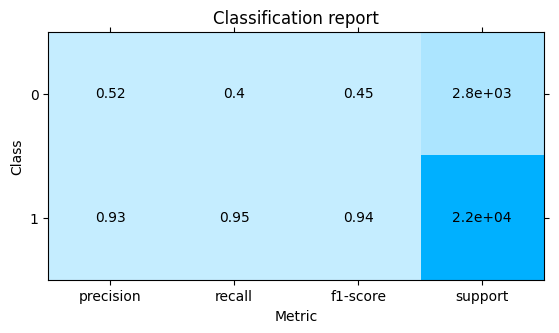

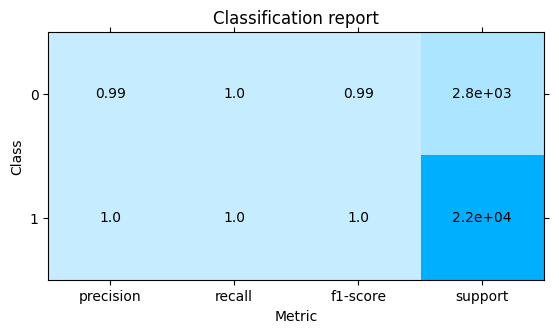

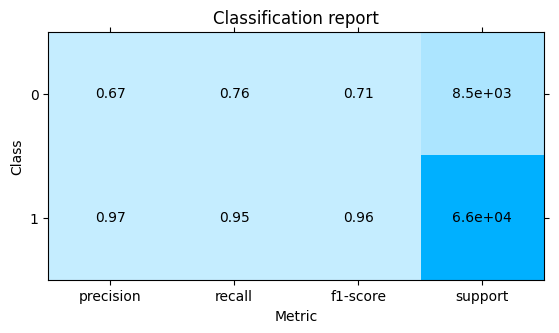

In [92]:
from sklearn_evaluation import plot 

y_pred_rf = rfc.fit(X_train, y_train).predict(X_test)
y_pred_lr = lr.fit(X_train, y_train).predict(X_test)
y_pred_hgbc = hgbc.fit(X_train, y_train).predict(X_test)
y_pred_svc = svc.fit(XX_train, yy_train).predict(XX_test)

target_names = ["0", "1"]

# report for random forest
cr_rf = plot.ClassificationReport.from_raw_data(
    y_test, y_pred_rf, target_names=target_names
)

# report for logistic regression
cr_lr = plot.ClassificationReport.from_raw_data(
    y_test, y_pred_lr, target_names=target_names
)

# report for histogram based gradient boosting
cr_hbgbc = plot.ClassificationReport.from_raw_data(
    y_test, y_pred_hgbc, target_names=target_names
)

# report for support vector machine
cr_svc = plot.ClassificationReport.from_raw_data(
    yy_test, y_pred_svc, target_names=target_names
)
